## Summarize Dialogue


In this notebook, the objective is to generate summaries of dialogues by leveraging prompt engineering techniques with the pretrained FLAN-T5 model from Hugging Face. Using the DialogSum dataset, which includes over 10,000 dialogues with manually labeled summaries and topics, we will assess the model’s performance through zero-shot and few-shot prompting methods. This approach allows us to explore FLAN-T5's inherent summarization capabilities and rene outputs based on specic prompts, providing insights into how well it condenses and interprets conversational data without additional training.

In [48]:
!pip install datasets==2.17.0 --quiet
!pip install torch==2.5.1 --quiet  
!pip install torchdata --quiet    
!pip install transformers
!pip install evaluate==0.4.3 --quiet
!pip install rouge_score==0.1.2 --quiet

### 1 - Import Libraries


In [51]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import evaluate


## 2 - Summarize Dialogue without Prompt



At the rst level, we will perform summarization without prompt engineering. Since FLAN-T5 is designed to perform well on multiple tasks, it can generate summaries without requiring specic prompt engineering.

In [55]:
# Load the dataset
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
# Load the FLAN-T5 model
model_name='google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# Load the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


Generating train split: 0 examples [00:00, ? examples/s]

C:\Users\pc\OneDrive\Documents\Lib\site-packages\datasets\download\streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

C:\Users\pc\OneDrive\Documents\Lib\site-packages\datasets\download\streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

C:\Users\pc\OneDrive\Documents\Lib\site-packages\datasets\download\streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

C:\Users\pc\OneDrive\Documents\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pc\.cache\huggingface\hub\models--google--flan-t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Using the DialogueSum dataset, we will evaluate whether the model can summarize the samples in the dataset. Here is the model's output compared to the reference summary:


In [81]:
example_indices = [40]
dash_line = '-'.join('' for x in range(100))
for i, index in enumerate(example_indices):
 dialogue = dataset['test'][index]['dialogue']
 summary = dataset['test'][index]['summary']
 inputs = tokenizer(dialogue, return_tensors='pt')
 output = tokenizer.decode(
 model.generate(
 inputs["input_ids"],
 max_new_tokens=50,
 )[0],
 skip_special_tokens=True
 )
 print(dash_line)
 print('Example ', i + 1)
 print(dash_line)
 print(f'INPUT PROMPT:\n{dialogue}')
 print(dash_line)
 print(f'BASELINE HUMAN SUMMARY:\n{summary}')
 print(dash_line)
 print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - WITHOUT PROMPT ENGINEERING:
Person1: It's ten to nine.



To evaluate the model, we will use the ROUGE score on 100 samples from the DialogueSum dataset. 

In [84]:
# Load the ROUGE metric
rouge = evaluate.load("rouge")
generated_summaries = []
reference_summaries = []
# Iterate over 100 sample
for i, sample in enumerate(dataset['test']):
 if i >= 100:
  break
 dialogue = sample['dialogue']
 reference_summary = sample['summary']
 inputs = tokenizer(dialogue, return_tensors='pt')
 output = model.generate(inputs["input_ids"], max_new_tokens=50)
 generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
 generated_summaries.append(generated_summary)
 reference_summaries.append(reference_summary)
# Compute ROUGE score
results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("ROUGE scores on 100 examples:", results)


ROUGE scores on 100 examples: {'rouge1': 0.22985888612649685, 'rouge2': 0.05351141075931014, 'rougeL': 0.19971145434168072, 'rougeLsum': 0.1995898529538735}


## 3 - Summarize Dialogue with an Instruction Prompt


In this section, we will apply prompt engineering techniques to evaluate the model's performan ce across dierent prompting scenarios: zero-shot, one-shot, and two-shot. We will use the ROUGE metric to measure and compare the quality of the model's output in each case. This analysis will help us understand how the number of examples provided in the prompt impacts the model's ability to generate accurate summaries.


### 3.1 - Zero Shot Inference with an Instruction Prompt

The objectif in this part is to take the dialogue and convert it into an instruction prompt. This is often called **zero shot inference**.


In [90]:
for i, index in enumerate(example_indices):
 dialogue = dataset['test'][index]['dialogue']
 summary = dataset['test'][index]['summary']
 prompt = f"""
Dialogue:
{dialogue}
What was going on?
 """
 # Input constructed prompt instead of the dialogue.
 inputs = tokenizer(prompt, return_tensors='pt')
 output = tokenizer.decode(
 model.generate(
 inputs["input_ids"],
 max_new_tokens=50,
 )[0],
 skip_special_tokens=True
 )
 print(dash_line)
 print('Example ', i + 1)
 print(dash_line)
 print(f'INPUT PROMPT:\n{prompt}')
 print(dash_line)
 print(f'BASELINE HUMAN SUMMARY:\n{summary}')
 print(dash_line)
 print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')
    

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
What was going on?
 
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for the train.



This is much better! But the model still does not pick up on the nuance of the conversations though. Now let's measure the ROUGE metric

In [95]:
rouge = evaluate.load("rouge")
generated_summaries = []
reference_summaries = []
for i, sample in enumerate(dataset['test']):
 if i >= 100:
  break
 dialogue = sample['dialogue']
 reference_summary = sample['summary']
 # Create a prompt for zero-shot summarization
 prompt = f"""
Dialogue:
{dialogue}
What was going on?
 """
 inputs = tokenizer(prompt, return_tensors='pt')
 output = model.generate(inputs["input_ids"], max_new_tokens=50)
 generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
 generated_summaries.append(generated_summary)
 reference_summaries.append(reference_summary)
# Compute ROUGE score
results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("ROUGE scores on 100 examples (zero-shot):", results)


ROUGE scores on 100 examples (zero-shot): {'rouge1': 0.28866833696322136, 'rouge2': 0.10115045577588985, 'rougeL': 0.24692684600956033, 'rougeLsum': 0.2482854774472725}


### 3.2 - One Shot Inference


The goal of this section is to provide context to the language model using oneshot inference, a technique known as 'in-context learning'.
Using this technique, we will compute the ROUGE metric.


In [103]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        prompt += f"""
Dialogue:
{dialogue}
What was going on?
{summary}
"""
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    prompt += f"""
Dialogue:
{dialogue}
What was going on?
"""
    return prompt


rouge = evaluate.load("rouge")
example_indices_full = [102]
generated_summaries = []
reference_summaries = []

for i in range(100):
    one_shot_prompt = make_prompt(example_indices_full, i)
    summary = dataset['test'][i]['summary']
    inputs = tokenizer(one_shot_prompt, return_tensors='pt')
    output = model.generate(inputs["input_ids"], max_new_tokens=50)
    generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_summaries.append(generated_summary)
    reference_summaries.append(summary)

results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("ROUGE scores for 100 examples (one-shot):", results)


ROUGE scores for 100 examples (one-shot): {'rouge1': 0.306552538404516, 'rouge2': 0.11128661307146379, 'rougeL': 0.2649343420536046, 'rougeLsum': 0.26551662157729183}


### 3.3 - Two Shots Inference


In this part, we will evaluate a two shots inference using ROUGE metric.


In [109]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        prompt += f"""
Dialogue:
{dialogue}
What was going on?
{summary}
"""
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    prompt += f"""
Dialogue:
{dialogue}
What was going on?
"""
    return prompt


example_indices_full = [102, 103]
generated_summaries = []
reference_summaries = []

for i in range(100):
    two_shot_prompt = make_prompt(example_indices_full, i)
    summary = dataset['test'][i]['summary']
    inputs = tokenizer(two_shot_prompt, return_tensors='pt')
    output = model.generate(inputs["input_ids"], max_new_tokens=50)
    generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_summaries.append(generated_summary)
    reference_summaries.append(summary)

results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("ROUGE scores for 100 examples (two-shot):", results)


ROUGE scores for 100 examples (two-shot): {'rouge1': 0.2903202749874811, 'rouge2': 0.10116693840747734, 'rougeL': 0.24787054904065486, 'rougeLsum': 0.2484963191718997}


## 4 - Results


By analyzing the metric values across the four prompt scenarios, this figure clearly shows that a one-shot inference may be the best choice for this use case.


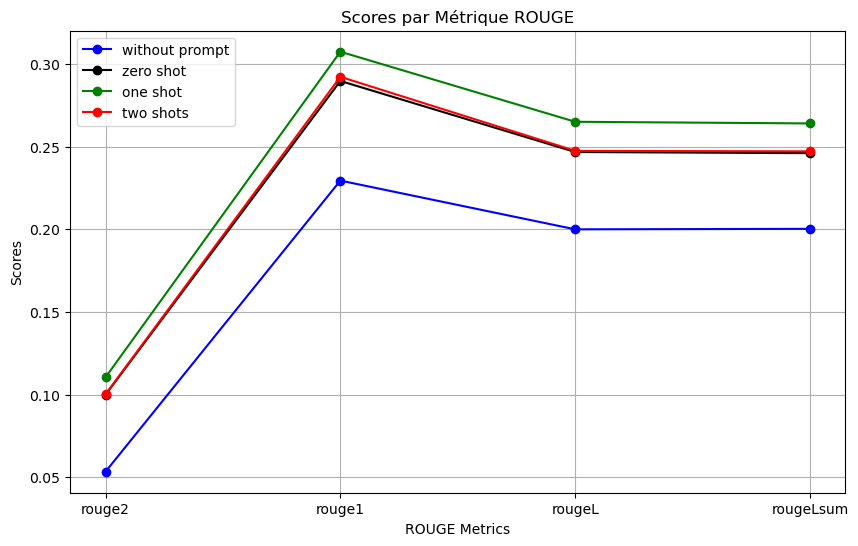

In [115]:
import matplotlib.pyplot as plt
rouge_metrics = ['rouge2', 'rouge1', 'rougeL', 'rougeLsum']
scores_by_prompt = {
 'without prompt': [0.0533, 0.2295, 0.2000, 0.2003],
 'zero shot': [0.0999, 0.2898, 0.2468, 0.2461],
 'one shot': [0.1104, 0.3075, 0.2651, 0.2641],
 'two shots': [0.1002, 0.2923, 0.2475, 0.2472]
}
colors = {
 'without prompt': 'blue',
 'zero shot': 'black',
 'one shot': 'green',
 'two shots': 'red'
}
plt.figure(figsize=(10, 6))
for prompt, scores in scores_by_prompt.items():
 plt.plot(rouge_metrics, scores, marker='o', color=colors[prompt], label=prompt)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('Scores par Métrique ROUGE')
plt.legend()
plt.grid(True)
plt.show()    